In [76]:
import os
import pandas as pd
import sqlalchemy as sql
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import scipy.optimize as sco

# https://pypi.org/project/yfinance/
import yfinance as yf

import plotly.graph_objects as go
import hvplot.pandas
import holoviews as hv
import seaborn as sns
import copy
import warnings

from pathlib import Path
# https://pandas-datareader.readthedocs.io/en/latest/
from pandas_datareader import data as pdr
from pandas import Timestamp as tstamp
from pandas import read_csv as rcsv
from pandas import read_sql_query as rsqq
from sqlalchemy import (
    create_engine as ce,
    inspect
)

# Import date and timedelta class
from datetime import date
from datetime import timedelta
from scipy import stats

## https://pyportfolioopt.readthedocs.io/en/latest/index.html
#from pypfopt import(                        
#    EfficientFrontier,
#    risk_models,
#    expected_returns,
#    plotting
#)
#
## https://pyportfolioopt.readthedocs.io/en/latest/index.html
#from pypfopt.discrete_allocation import(    
#    DiscreteAllocation,
#    get_latest_prices
#)

from MCForecastTools import MCSimulation
from calculations import MPTCalculations as mpt
from metrics import QuantMetrics as qm
from dataset import DataCollection as ds

warnings.filterwarnings('ignore')

print(f"Package imports and dependencies resolved")

Package imports and dependencies resolved


### Modern Portfolio Theory Based Portfolio Analysis and Optimization

---
Steps Involved:
1. Project Settings
2. Data Preparation (Fetch, Clean and Format)
3. Quant Analysis
4. Visualizations
5. Summary

### 1. Project Settings

In [77]:
# Specifiy date range for data
# Set start and end dates of 5 years "5Y" back from your current date
end_date = pd.to_datetime('today')
# 5 years
start_date = end_date - np.timedelta64(5, 'Y')
start, end = start_date, end_date
# Verify date range
print(f"Start date: {start} and End date: {end}")

Start date: 2017-10-19 07:21:19.524707 and End date: 2022-10-19 12:27:19.524707


In [78]:
# Specify portfolio sectors - basket of market index and assets - S&P 500 Index (^GSPC) and Tech Stocks List
basket_list = ds.market + ds.tech_list

print("Basket of stocks")
print(basket_list)

Basket of stocks
['^GSPC', 'AAPL', 'IBM', 'TSLA', 'GOOGL', 'MSFT', 'CSCO', 'TSM', 'NVDA']


### 2. Data Preparation

In [79]:
# Dataframe closing prices of basket, i.e. market index and assets
# Fetch data from Yahoo Finance API
stock_data, raw_data = ds.get_raw_data(basket_list, start, end)
stock_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)
stock_data = stock_data.reset_index()
raw_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)

In [80]:
# Output raw data is raw_frame_close
display(raw_data.shape)
# Review random 5 rows from dataframe
display(raw_data.sample(5))

(1259, 54)

Attributes    Adj Close                                                  \
Symbols     SP500_index        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2022-06-29  3818.830078  139.036865  138.959213  228.490005  111.701500   
2019-09-09  2978.429932   52.384129  117.515839   15.452667   60.263500   
2020-03-30  2626.649902   62.659790   95.147430   33.475334   57.315498   
2020-06-16  3124.739990   86.813614  106.857315   65.475334   72.323502   
2020-09-24  3246.590088  106.929207  102.149452  129.263336   71.142998   

Attributes                                                      Close  ...  \
Symbols           MSFT       CSCO        TSM        NVDA  SP500_index  ...   
Date                                                                   ...   
2022-06-29  259.708740  42.106388  83.179565  155.373825  3818.830078  ...   
2019-09-09  133.616638  43.906834  40.807526   44.947636  2978.429932  ...   
2020-03-30  156.638443  36.987343  45.563862   66.224915  2626.649902  ...   
2020-06-16  189.758163  43.042450  53.167370   90.490555  3124.739990  ...   
2020-09-24  199.670242  35.326805  75.628838  123.252113  3246.590088  ...   

Attributes        Open        Volume                                       \
Symbols           NVDA   SP500_index         AAPL        IBM         TSLA   
Date                                                                        
2022-06-29  158.139999  3.458850e+09   66242400.0  4161500.0   82897200.0   
2019-09-09   44.974998  4.002890e+09  109237600.0  4421024.0   72040500.0   
2020-03-30   63.840000  5.746220e+09  167976400.0  5820467.0  179971500.0   
2020-06-16   92.250000  5.829240e+09  165428800.0  5864608.0  210766500.0   
2020-09-24  120.722504  4.599470e+09  167743300.0  3709325.0  289683300.0   

Attributes                                                             
Symbols          GOOGL        MSFT        CSCO        TSM        NVDA  
Date                                                                   
2022-06-29  24716000.0  20069800.0  13450800.0  7981300.0  48235200.0  
2019-09-09  31854000.0  25773900.0  21175100.0  4677000.0  41752400.0  
2020-03-30  58736000.0  63420300.0  27120300.0  8428300.0  60225200.0  
2020-06-16  30648000.0  42556700.0  28074600.0  8827200.0  53571600.0  
2020-09-24  34552000.0  31202500.0  30910400.0  9940900.0  73124000.0  

[5 rows x 54 columns]

In [81]:
# Output cleaned data to 'Close' prices is stock_data, cut table down to 29 columns from 174 columns
display(stock_data.shape)
# Review random 5 rows from dataframe
display(stock_data.sample(5))

(1259, 10)

Symbols,Date,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
1218,2022-08-23,4128.729980,167.229996,134.740005,296.453339,113.860001,276.440002,47.410000,86.029999,171.809998
378,2019-04-24,2927.250000,51.790001,133.795410,17.243999,63.002499,125.010002,56.880001,45.410000,47.792500
680,2020-07-06,3179.719971,93.462502,114.904396,91.438667,74.982498,210.699997,46.419998,61.880001,98.392502
977,2021-09-08,4514.069824,155.110001,132.571701,251.289993,143.690994,300.209991,58.680000,121.889999,223.389999
946,2021-07-26,4422.299805,148.990005,136.491394,219.206665,134.035004,289.049988,55.470001,115.650002,192.940002


In [82]:
# Import the [offline stored] data from the csv file
# Generate dataframe setting the DatetimeIndex with 'date' as as index. 
working_raw_data = rcsv(
    Path('data/raw_frame_close.csv'),
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
    header = [0,1]
)

# Output dataframe name is working_raw_frame_close
print('Sample row of DataFrame from local csv data source path:')
display(working_raw_data.shape)

# Display sample 5 rows of dataframe
display(working_raw_data.sample(5))

Sample row of DataFrame from local csv data source path:


(1259, 54)

Attributes    Adj Close                                                  \
Symbols           ^GSPC        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2018-01-04  2723.989990   41.201782  123.091415   20.974667   54.787998   
2022-06-15  3789.989990  135.242142  135.354630  233.000000  109.764503   
2018-02-12  2656.000000   38.902359  116.385414   21.048668   52.728001   
2020-03-12  2480.639893   61.041714   86.620979   37.369999   55.577499   
2022-03-17  4411.669922  160.161880  124.853310  290.533325  133.839005   

Attributes                                                       Close  ...  \
Symbols           MSFT       CSCO         TSM        NVDA        ^GSPC  ...   
Date                                                                    ...   
2018-01-04   82.263962  33.762096   36.075947   52.872269  2723.989990  ...   
2022-06-15  251.226746  43.009792   88.164368  165.220901  3789.989990  ...   
2018-02-12   84.171585  35.156231   36.980236   56.446762  2656.000000  ...   
2020-03-12  135.942993  30.455845   45.956806   53.936943  2480.639893  ...   
2022-03-17  293.910126  54.781467  105.336288  247.534103  4411.669922  ...   

Attributes        Open        Volume                                        \
Symbols           NVDA         ^GSPC         AAPL         IBM         TSLA   
Date                                                                         
2018-01-04   53.939999  3.695260e+09   89738400.0   7903785.0  149194500.0   
2022-06-15  160.949997  4.474610e+09   91533000.0   4606900.0  119131800.0   
2018-02-12   58.840000  4.055790e+09  243278000.0   6151944.0   93417000.0   
2020-03-12   56.365002  8.829380e+09  418474000.0  13088284.0  283636500.0   
2022-03-17  241.199997  4.174170e+09   75615400.0   3671900.0   66582900.0   

Attributes                                                               
Symbols          GOOGL        MSFT        CSCO         TSM         NVDA  
Date                                                                     
2018-01-04  26052000.0  21912000.0  20731400.0   4876600.0   58326800.0  
2022-06-15  39698000.0  33111700.0  22525100.0  11742500.0   56393600.0  
2018-02-12  56240000.0  35720300.0  38210700.0   6573300.0  109317200.0  
2020-03-12  94326000.0  93226400.0  51855300.0  15942200.0   81654000.0  
2022-03-17  28264000.0  30816600.0  18830500.0   8042000.0   47194100.0  

[5 rows x 54 columns]

In [83]:
# Verify Close columns of each stocks and index
working_raw_data['Close']

Symbols,^GSPC,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2017-10-19,2562.100098,38.994999,153.824097,23.454000,50.091999,77.910004,33.750000,41.070000,49.450001
2017-10-20,2575.209961,39.062500,154.942642,23.006666,50.253502,78.809998,34.250000,41.119999,49.224998
2017-10-23,2564.979980,39.042500,152.533463,22.468000,49.277000,78.830002,34.349998,41.209999,49.154999
2017-10-24,2569.129883,39.275002,149.024857,22.489332,49.424500,78.860001,34.580002,41.320000,49.669998
2017-10-25,2557.149902,39.102501,146.749527,21.722668,49.573002,78.629997,34.299999,41.160000,48.415001
...,...,...,...,...,...,...,...,...,...
2022-10-13,3669.909912,142.990005,121.790001,221.720001,99.059998,234.240005,40.610001,66.620003,119.599998
2022-10-14,3583.070068,138.380005,120.040001,204.990005,96.559998,228.559998,40.200001,63.919998,112.269997
2022-10-17,3677.949951,142.410004,121.519997,219.350006,99.970001,237.529999,41.299999,64.889999,118.879997


### Create 'basket' from SQLite temp db

In [84]:
# Fetch date indexed and unindexed data frames created out of SQLite temp db
sql_basket_indexed_df, sql_basket_df = ds.sqlite_data(stock_data)

print("Unindexed dataframe counts and column summary")
display(sql_basket_df.shape) 
# Display sample 5 rows of unindexed dataframe
display(sql_basket_df.sample(5))

print("Indexed dataframe counts and column summary")
display(sql_basket_indexed_df.shape) 

# Display sample 5 rows of indexed datafarme
display(sql_basket_indexed_df.sample(5))

Unindexed dataframe counts and column summary


(1259, 10)

,Date,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
544,2019-12-18,3191.139893,69.934998,128.499039,26.209999,67.595497,154.369995,46.639999,59.099998,57.377499
610,2020-03-25,2475.560059,61.380001,101.195030,35.950001,55.081001,146.919998,37.669998,49.000000,61.404999
842,2021-02-25,3829.340088,120.989998,117.084129,227.406662,100.797501,228.990005,45.520000,126.000000,133.074997
661,2020-06-08,3232.389893,83.364998,129.780121,63.327999,72.402000,188.360001,48.130001,55.570000,88.050003
305,2019-01-08,2574.409912,37.687500,114.560226,22.356667,54.268501,102.800003,43.560001,34.939999,34.957500


Indexed dataframe counts and column summary


(1259, 9)

,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2018-11-23,2632.560059,43.072498,112.036331,21.722000,51.505001,103.070000,44.540001,35.959999,36.250000
2021-01-05,3726.860107,131.009995,120.592735,245.036667,87.002502,217.899994,43.980000,112.769997,134.047501
2020-11-18,3567.790039,118.029999,111.634796,162.213333,87.031998,211.080002,41.320000,96.930000,134.287506
2019-04-01,2867.189941,47.810001,136.998093,19.278667,59.949001,119.019997,54.980000,41.369999,45.570000
2017-11-03,2587.840088,43.125000,144.913956,20.406000,52.499500,84.139999,34.470001,42.189999,52.172501


### 3. Quant Analysis

In [85]:
# Display constants being used in quant analysis
print("Number of trading days per year = ", qm.num_trading_days)
print("Risk free rate = ", qm.risk_free_rate)
print("Number of random portfolio runs = ", qm.num_random_portfolio_run)
print("Number of days in rolling window = ", qm.rolling_window_days)
print("Number of days of input dataframe to use as historical data = ", mpt.historical_days_percent)
print("Number of days of input dataframe to use as test/experiment data  = ", mpt.test_days_percent)

Number of trading days per year =  252
Risk free rate =  0.0275
Number of random portfolio runs =  10000
Number of days in rolling window =  20
Number of days of input dataframe to use as historical data =  0.8
Number of days of input dataframe to use as test/experiment data  =  0.19999999999999996


In [86]:
display(sql_basket_indexed_df.shape)

(1259, 9)

In [87]:
# Break up the input asset price data frame into 2 chunks
# (1) For use of historical data to determine what the optimum portfolio selection should be
# (2) For test purposes,test how wll the portfolio allocation performs
num_days_total = sql_basket_indexed_df.shape[0]
num_historical_days_percent = round(num_days_total * mpt.historical_days_percent)
num_test_days_percent = round(num_days_total * mpt.test_days_percent)

print("Total # of days in asset dataframe = ", num_days_total)
print("Total # of days will use for hisotrical data = ", num_historical_days_percent)
print("Total # of days will use for testing results = ", num_test_days_percent)


# Extract the days from full dataframe will use for historical data
asset_mkt_prices_historical_df = sql_basket_indexed_df.iloc[0:num_historical_days_percent-1, :].copy()
asset_mkt_prices_test_df = sql_basket_indexed_df.iloc[num_historical_days_percent:num_days_total-1,:].copy()

Total # of days in asset dataframe =  1259
Total # of days will use for hisotrical data =  1007
Total # of days will use for testing results =  252


In [88]:
# Plot the asset prices
asset_mkt_prices_historical_df.drop('SP500_index', axis=1, inplace=False).hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Performance of Historical Market & Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [89]:
# Plot the asset prices
asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False).hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="(Test) Market & Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [90]:
asset_mkt_prices_returns_df.hvplot.hist(bins=100, subplots=True, width=400, group_label='Ticker', grid=True).cols(3)

:NdLayout   [Default]
   :Histogram   [NVDA]   (NVDA_count)

#### Calculate Descriptive Stats
---
* Asset Returns, Standard Deviation, Cumulative Returns, Covariance, Correlation Matrix, Sharpe Ratio

In [91]:
# Compute the frequency components on asset prices
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_mkt_prices_historical_df)

In [92]:
# Review daily returns DataFrame.
print("Asset Returns:")
display(asset_mkt_prices_returns_df.shape)
# Display randow 5 rows of the returns
display(asset_mkt_prices_returns_df.sample(5))

Asset Returns:


(1005, 9)

,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2021-03-12,0.001015,-0.007625,0.003697,-0.008391,-0.024060,-0.005820,0.000410,-0.018909,-0.010582
2021-06-17,-0.000436,0.012601,-0.015085,0.019393,0.008040,0.013676,-0.006359,0.009321,0.047557
2017-11-16,0.008196,0.011947,0.013732,0.003855,0.011636,0.002651,0.051891,0.013481,0.007763
2018-09-05,-0.002803,-0.006525,0.006727,-0.028413,-0.010080,-0.028825,-0.009638,0.002494,-0.018611
2018-11-14,-0.007567,-0.028247,-0.005296,0.015558,0.006307,-0.018422,-0.017509,0.011765,-0.010637


In [93]:
# Plot the asset cumulative returns
asset_mkt_prices_cum_returns_df.hvplot.line(
    ylabel="Cum Returns", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Market & Assets Cumulative Returns"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Asset & Market: Daily Returns Box Plot'}>

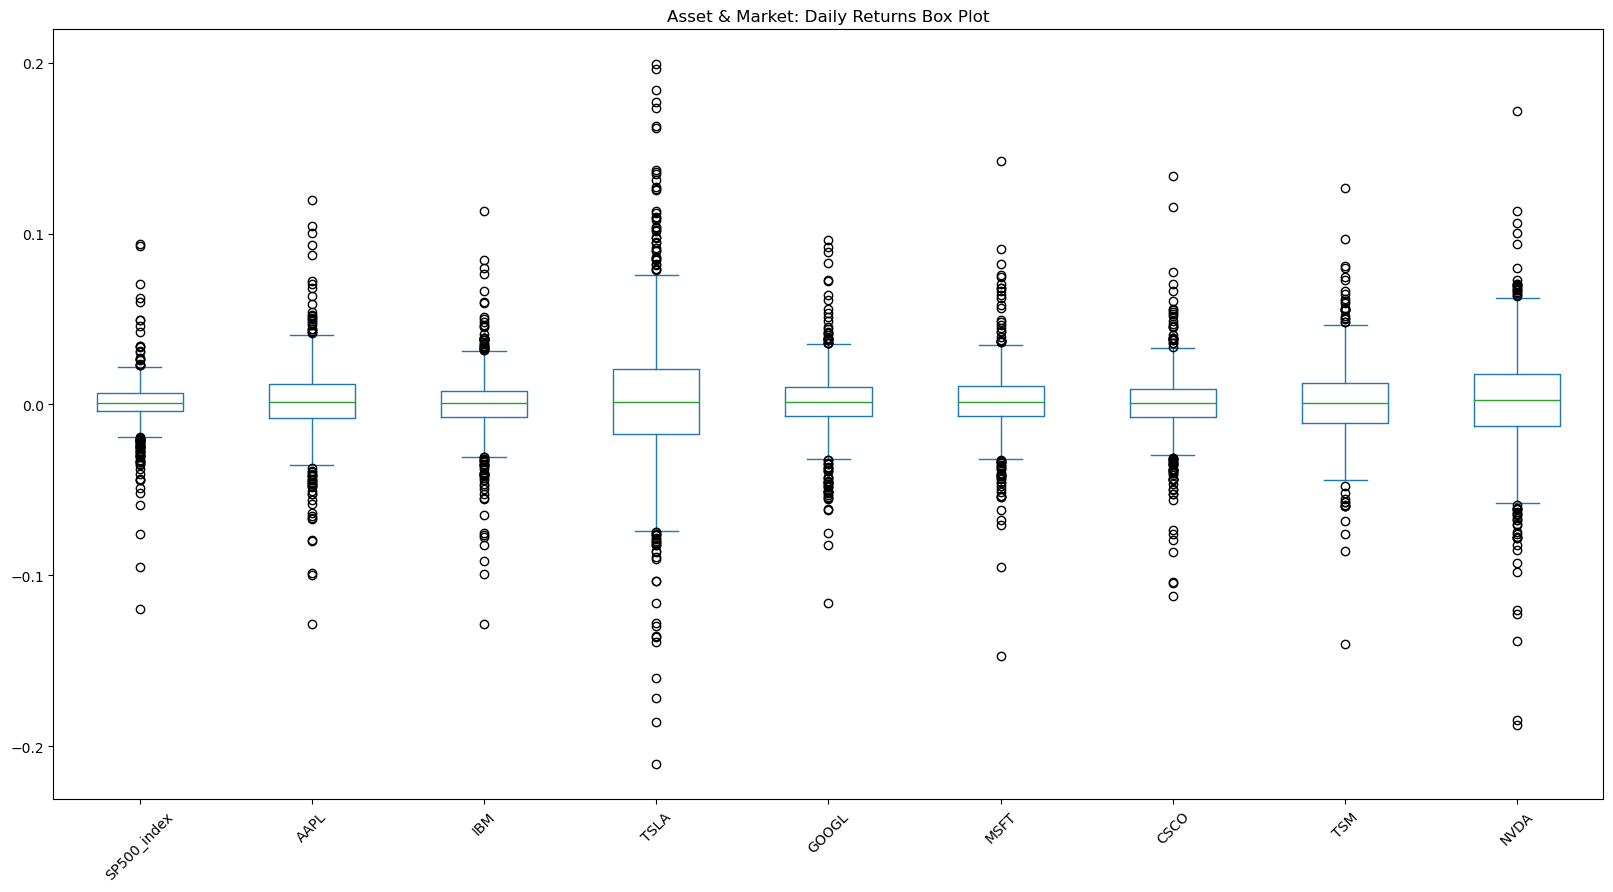

In [94]:
# Use the daily return data to create box plots to visualize the volatility of the assets 
asset_mkt_prices_returns_df.plot.box(figsize=(20, 10), rot=45, title = "Asset & Market: Daily Returns Box Plot")

In [95]:
# Sort the asset deviations
asset_mkt_prices_ann_std_sorted_df = asset_mkt_prices_ann_std_df.sort_values()

print("Asset annualized standard deviations (Sorted):")
display(asset_mkt_prices_ann_std_sorted_df)

Asset annualized standard deviations (Sorted):


SP500_index    0.210733
IBM            0.280496
CSCO           0.290095
GOOGL          0.290225
MSFT           0.297898
AAPL           0.326891
TSM            0.334026
NVDA           0.472415
TSLA           0.639072
dtype: float64

In [96]:
# Dispaly the (sorted) asset sharpe ratios
print("Assets & Market: Annual Sharpe Ratio (Sorted):")
display(asset_prices_sharpe_ratio_df.sort_values())

asset_prices_sharpe_ratio_df.hvplot(
    kind = 'bar',
    width = 800,
    height = 500,
    hover_color = 'magenta',
    rot = 45,
    title = "Assets & Market: Annual Sharpe Ratio")

Assets & Market: Annual Sharpe Ratio (Sorted):


IBM            0.031476
CSCO           0.570546
SP500_index    0.772827
TSM            0.942360
NVDA           1.037089
GOOGL          1.050654
AAPL           1.179774
MSFT           1.304767
TSLA           1.305564
dtype: float64

:Bars   [index]   (0)

In [97]:
# Drop the market from asset/mkt data frame
asset_prices_df = asset_mkt_prices_historical_df.drop(['SP500_index'], axis=1, inplace=False)
print("Asset Prices DataFrame (does not include market)")
display(asset_prices_df)

market_df = pd.DataFrame(asset_mkt_prices_returns_df['SP500_index'])

# Recompute frequence components (e.g. covariance matrix will be different).
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_prices_df)

Asset Prices DataFrame (does not include market)


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,
2017-10-19,38.994999,153.824097,23.454000,50.091999,77.910004,33.750000,41.070000,49.450001
2017-10-20,39.062500,154.942642,23.006666,50.253502,78.809998,34.250000,41.119999,49.224998
2017-10-23,39.042500,152.533463,22.468000,49.277000,78.830002,34.349998,41.209999,49.154999
2017-10-24,39.275002,149.024857,22.489332,49.424500,78.860001,34.580002,41.320000,49.669998
2017-10-25,39.102501,146.749527,21.722668,49.573002,78.629997,34.299999,41.160000,48.415001
...,...,...,...,...,...,...,...,...
2021-10-12,141.509995,134.292542,268.573334,136.449005,292.880005,54.279999,109.199997,206.710007
2021-10-13,140.910004,134.569794,270.359985,137.582001,296.309998,54.619999,109.980003,209.389999
2021-10-14,143.759995,137.084137,272.773346,141.151001,302.750000,55.650002,112.559998,217.460007


In [98]:
print("Annual Covariance Matrix:")
display(asset_mkt_prices_ann_cov_mtrx_df.head())

print("Correlation Matrix:")
display(asset_mkt_prices_ann_corr_mtrx_df)

Annual Covariance Matrix:


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
AAPL,0.106858,0.043444,0.087518,0.064072,0.073715,0.057470,0.061457,0.098934
IBM,0.043444,0.078678,0.041533,0.041481,0.045291,0.051387,0.041211,0.055862
TSLA,0.087518,0.041533,0.408413,0.069021,0.081788,0.051095,0.077431,0.125799
GOOGL,0.064072,0.041481,0.069021,0.084230,0.068314,0.049796,0.051467,0.087424
MSFT,0.073715,0.045291,0.081788,0.068314,0.088743,0.058323,0.057111,0.098547


Correlation Matrix:


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
AAPL,1.000000,0.473803,0.418931,0.675354,0.756983,0.606041,0.562841,0.640647
IBM,0.473803,1.000000,0.231693,0.509558,0.542028,0.631519,0.439853,0.421566
TSLA,0.418931,0.231693,1.000000,0.372133,0.429606,0.275604,0.362731,0.416680
GOOGL,0.675354,0.509558,0.372133,1.000000,0.790144,0.591455,0.530903,0.637634
MSFT,0.756983,0.542028,0.429606,0.790144,1.000000,0.674889,0.573947,0.700252
CSCO,0.606041,0.631519,0.275604,0.591455,0.674889,1.000000,0.483229,0.547049
TSM,0.562841,0.439853,0.362731,0.530903,0.573947,0.483229,1.000000,0.622827
NVDA,0.640647,0.421566,0.416680,0.637634,0.700252,0.547049,0.622827,1.000000


[Text(0.5, 1.0, 'Asset Prices Correlation Matrix')]

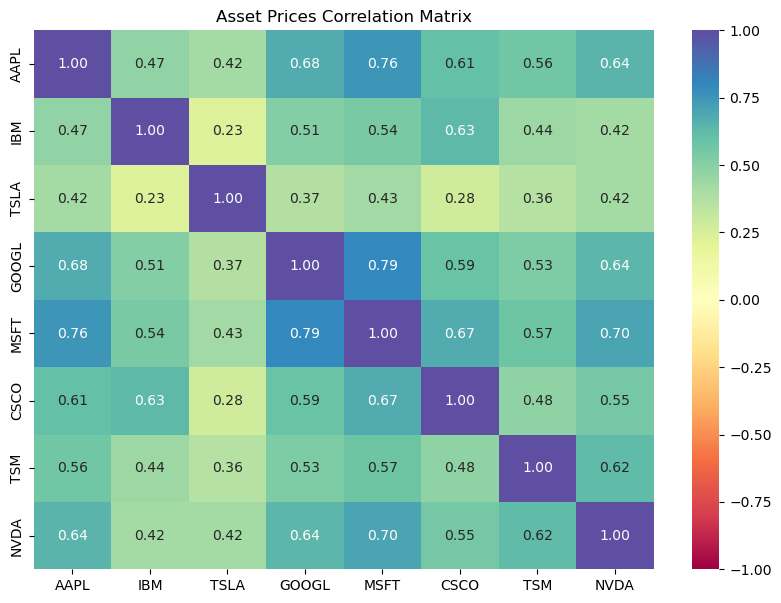

In [99]:
# Use the `heatmap` function from the seaborn library to visualize the correlation matrix
plt.figure(figsize = (10,7))
sns.heatmap(
    asset_mkt_prices_ann_corr_mtrx_df, 
    annot=True, 
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    cmap="Spectral"
).set(
    title='Asset Prices Correlation Matrix')

In [100]:
print("Annual average asset returns:")
display(asset_mkt_prices_ann_returns_mean)

Annual average asset returns:


AAPL     0.385657
IBM      0.008829
TSLA     0.834350
GOOGL    0.304926
MSFT     0.388687
CSCO     0.165512
TSM      0.314773
NVDA     0.489937
dtype: float64

### Efficient Frontier Computation

In [101]:
# Determine the efficient frontier components
efficient_frontier_df = qm.mpt_qa_get_efficient_frontier(asset_prices_df, asset_mkt_prices_ann_returns_mean, asset_mkt_prices_ann_cov_mtrx_df)

print("Efficient Frontier DataFrame:")
display(efficient_frontier_df.shape)

print("Print random 5 rows of Efficient Frontier sample points")
display(efficient_frontier_df.sample(5))

Efficient Frontier DataFrame:


(10000, 11)

Print random 5 rows of Efficient Frontier sample points


,Returns,Volatility,SharpeRatio,AAPL_W,IBM_W,TSLA_W,GOOGL_W,MSFT_W,CSCO_W,TSM_W,NVDA_W
2021,0.413944,4.919970,0.078546,0.186279,0.185249,0.235991,0.002443,0.016190,0.065870,0.144210,0.163769
3626,0.397866,4.647861,0.079685,0.092652,0.078815,0.165595,0.066847,0.129674,0.146557,0.162590,0.157271
4019,0.291000,4.256471,0.061906,0.090365,0.280966,0.072091,0.164279,0.083727,0.113580,0.019686,0.175305
2658,0.291151,4.123572,0.063938,0.217559,0.182517,0.017022,0.259898,0.037066,0.067632,0.116306,0.102001
652,0.363658,4.527016,0.074256,0.022393,0.113674,0.140025,0.245344,0.039705,0.159419,0.093338,0.186102


In [102]:
# Select the following portfolio allocations:
# (1) Based on the "minimum" risk
# (2) Based on the "maximum" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility, portfolio_max_volatility, portfolio_opt_sharpe_ratio = qm.mpt_qa_return_portfolio_allocations(efficient_frontier_df)

print("Efficient Frontier: Min Volatility Point:")
display(portfolio_min_volatility)
print("\nEfficient Frontier: Max Volatility Point:")
display(portfolio_max_volatility)
print("\nEfficient Frontier: Opt Sharpe Ratio Volatility Point:")
display(portfolio_opt_sharpe_ratio)

Efficient Frontier: Min Volatility Point:


Returns        0.233345
Volatility     3.842484
SharpeRatio    0.053571
AAPL_W         0.141959
IBM_W          0.231387
TSLA_W         0.023208
GOOGL_W        0.238709
MSFT_W         0.023380
CSCO_W         0.220013
TSM_W          0.117322
NVDA_W         0.004023
Name: 6169, dtype: float64


Efficient Frontier: Max Volatility Point:


Returns        0.557191
Volatility     6.216881
SharpeRatio    0.085202
AAPL_W         0.013246
IBM_W          0.024643
TSLA_W         0.486433
GOOGL_W        0.083731
MSFT_W         0.126318
CSCO_W         0.178775
TSM_W          0.004349
NVDA_W         0.082504
Name: 7649, dtype: float64


Efficient Frontier: Opt Sharpe Ratio Volatility Point:


Returns        0.508124
Volatility     5.270904
SharpeRatio    0.091184
AAPL_W         0.142420
IBM_W          0.009597
TSLA_W         0.309935
GOOGL_W        0.023855
MSFT_W         0.297472
CSCO_W         0.004373
TSM_W          0.189186
NVDA_W         0.023162
Name: 5253, dtype: float64

In [103]:
# Plot the efficient frontier #3 (Efficient frontier + porfolio selection points + 3rd color dimension of the sharpe ratio points)
scatter = hv.Scatter((efficient_frontier_df['Volatility'], efficient_frontier_df['Returns'], efficient_frontier_df.loc[:,'SharpeRatio']), 'Volatility', ['Return', 'Sharpe Ratio'])
max_sharpe = hv.Scatter([(portfolio_opt_sharpe_ratio[1],portfolio_opt_sharpe_ratio[0])])
min_volatility = hv.Scatter([(portfolio_min_volatility[1],portfolio_min_volatility[0])])
max_volatility = hv.Scatter([(portfolio_max_volatility[1],portfolio_max_volatility[0])])

scatter.opts(title="Efficient Frontier + Min/Max/OptSharpeRatio Selections", color='Sharpe Ratio', cmap='plasma', width=800, height=600, colorbar=True, padding=0.1) *\
max_sharpe.opts(color='blue', line_color='black', size=15,) *\
min_volatility.opts(color='yellow', line_color='black', size=15) *\
max_volatility.opts(color='red', line_color='black', size=15)


:Overlay
   .Scatter.I   :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Scatter.II  :Scatter   [x]   (y)
   .Scatter.III :Scatter   [x]   (y)
   .Scatter.IV  :Scatter   [x]   (y)

### Visualization for: "mpt_performance_eval.py"

In [104]:
# Select the following portfolio allocations:
# (1) Based on the "minimum volatility" risk
# (2) Based on the "maximum returns" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_min_volatility)
portfolio_max_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_max_volatility)
portfolio_opt_sharpe_ratio_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_opt_sharpe_ratio)

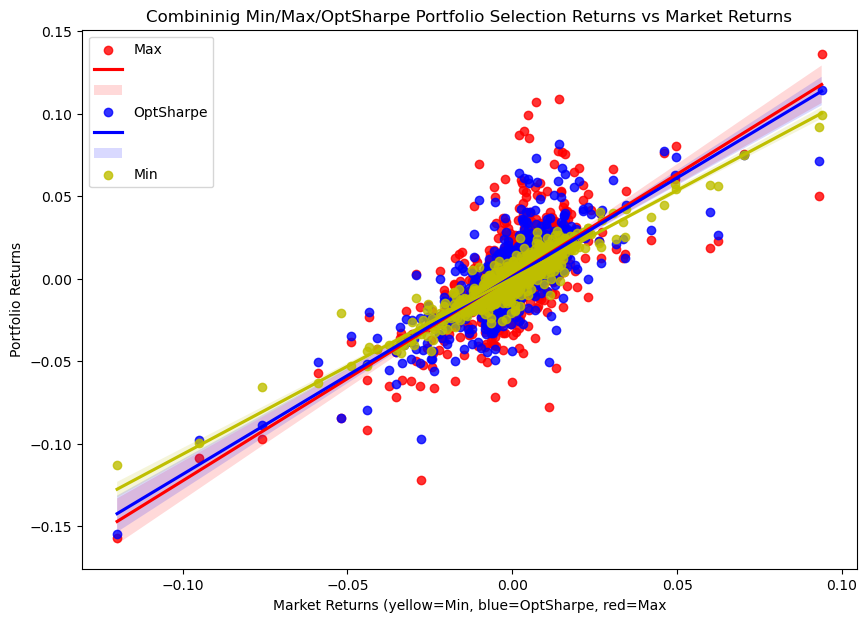

In [105]:
plt.subplots(figsize=(10,7))

x_df = market_df.reset_index(drop=True)
y_df = portfolio_max_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "MaxVol"]
sns.regplot(x="Market", y="MaxVol", data=z_df, color='r')

y_df = portfolio_opt_sharpe_ratio_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "OptSharpe"]
sns.regplot(x="Market", y="OptSharpe", data=z_df, color='b')

y_df = portfolio_min_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "MinReturns"]
sns.regplot(x="Market", y="MinReturns", data=z_df, color='y')

plt.xlabel("Market Returns (yellow=Min, blue=OptSharpe, red=Max")
plt.ylabel("Portfolio Returns")
plt.legend(["Max", "", "", "OptSharpe", "", "", "Min"])
plt.title("Combininig Min/Max/OptSharpe Portfolio Selection Returns vs Market Returns")

plt.show()

<AxesSubplot:title={'center':'Portfolio Composition - Min Protfolio'}, ylabel='weights'>

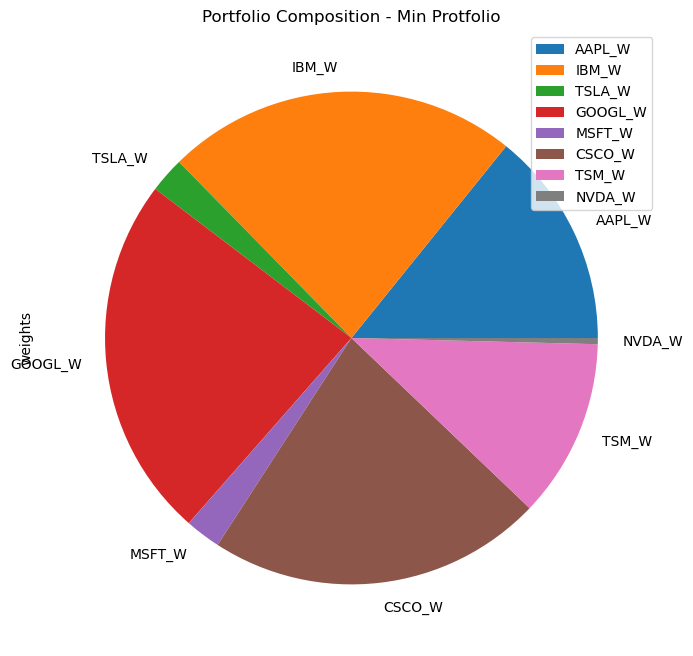

In [106]:
portfolio_min_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_min_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_min_weights.plot.pie(
    y='weights', 
    title='Portfolio Composition - Min Protfolio',
    figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Max Protfolio'}, ylabel='weights'>

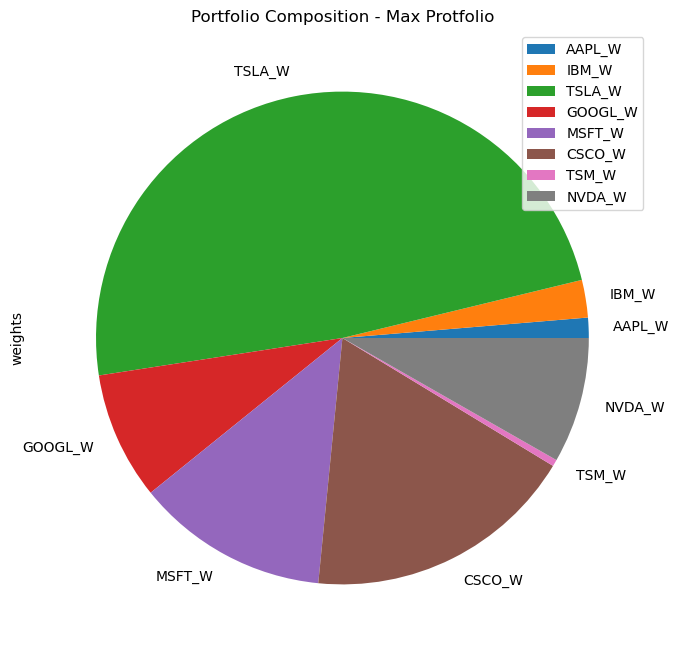

In [107]:
portfolio_max_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_max_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_max_weights.plot.pie(y='weights', title='Portfolio Composition - Max Protfolio', figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Opt Sharpe Ratio Protfolio'}, ylabel='weights'>

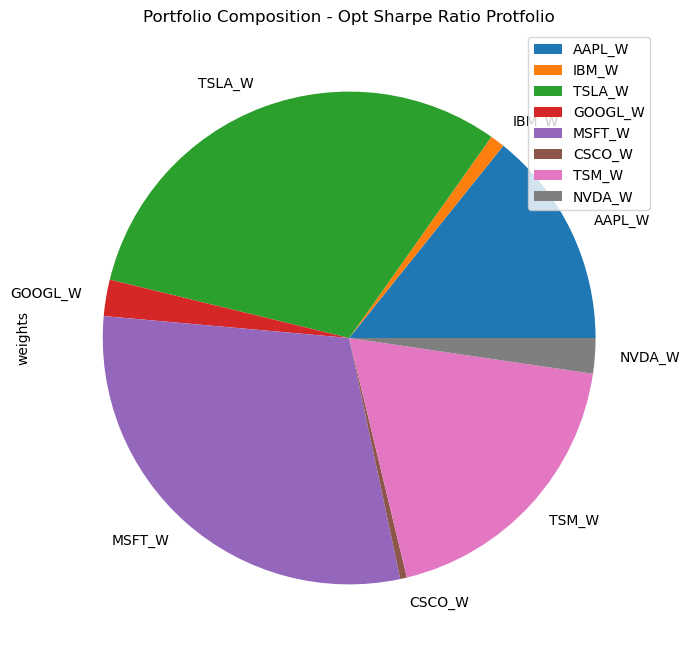

In [108]:
portfolio_opt_sharpe_ratio_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_opt_sharpe_ratio)

# Plot the pie charts of the porfolio allocation/weights
portfolio_opt_sharpe_ratio_weights.plot.pie(y='weights', title='Portfolio Composition - Opt Sharpe Ratio Protfolio', figsize=(10,8))

### Compute Actual Realized Portfolio Value under the Test dataframe components

In [109]:
asset_prices_test_beg_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_historical_days_percent, :]).drop('SP500_index', axis=0, inplace=False)
asset_prices_test_end_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_days_total-1, :]).drop('SP500_index', axis=0, inplace=False)

print("Beginning and end dates used for the testing the performance of the portfolio")
display(asset_prices_test_beg_df.T)
display(asset_prices_test_end_df.T)

Beginning and end dates used for the testing the performance of the portfolio


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
2021-10-20,149.259995,135.659653,288.600006,141.768997,307.410004,56.200001,115.589996,221.029999


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
2022-10-19,143.479996,122.886703,219.869995,100.199997,236.720001,41.799999,63.450001,120.309998


### Monte-Carlo Dataframe Weights List

In [110]:
# Arrange Monte Carlo dataframe weights list
portfolio_mc_min_weights = mpt.mpt_pe_get_mc_weights(portfolio_min_weights)
portfolio_mc_max_weights = mpt.mpt_pe_get_mc_weights(portfolio_max_weights)
portfolio_mc_opt_sharpe_ratio_weights = mpt.mpt_pe_get_mc_weights(portfolio_opt_sharpe_ratio_weights)

In [111]:
investment_pnl_min = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_min_weights))[0][0]
investment_pnl_max = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_max_weights))[0][0]
investment_pnl_opt_sharpe_ratio = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_opt_sharpe_ratio_weights))[0][0]

print("Actual realized portfolio value for min/max/opt_sharpe allocations:")
display(investment_pnl_min)
display(investment_pnl_max)
display(investment_pnl_opt_sharpe_ratio)

Actual realized portfolio value for min/max/opt_sharpe allocations:


7948.56383895874

7493.963272094727

7721.166622161865

### Run Monte-Carlo Simulations
---
* Compute expected Returns, and 
* Compare against realized returns

In [112]:
print("Number of MC runs:", mpt.num_mc_runs)

Number of MC runs: 500


In [113]:
# Slice the "test" dataframe to use for MC sims to predict returns
asset_mc_test_df = asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False)

In [114]:
# Arrange Monte Carlo dataframe to have tuples for column names
asset_prices_mc_col_df = mpt.mpt_pe_get_mc_porfolio_df(asset_mc_test_df)

In [115]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_min_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_min_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Min)")
MC_min_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Min)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-12     0.003418   97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   

                         
           daily_return  
Date                     
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645

In [116]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_min_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.989142,1.008256,1.005612,1.001940,1.005562,0.994924,1.008194,0.986916,1.005663,1.003991,...,0.995730,0.992933,0.988824,0.994117,1.006375,1.008199,0.985108,0.998917,1.004617,0.999719
2,0.997997,1.013548,1.005495,0.999968,0.994416,1.007102,1.016245,0.983545,0.987227,1.013288,...,1.002503,0.991172,0.992660,0.985367,1.016469,1.009867,0.972647,1.013589,1.002654,0.983432
3,1.002177,1.017456,1.015597,1.000383,1.006453,1.010602,0.989157,0.978106,0.997625,1.013422,...,1.005130,0.978016,0.984961,0.991499,1.015873,1.001666,0.971714,1.006069,1.021063,0.969396
4,1.006353,1.016861,1.013167,0.991179,1.004900,0.999242,0.995685,0.990807,0.993042,1.013850,...,1.001585,0.977976,0.964715,0.997244,1.016651,1.011835,0.967278,0.990688,1.019120,0.959880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.757353,0.863384,1.000158,0.772005,0.898532,0.648955,0.712652,0.805292,0.849356,0.764436,...,0.835633,0.734826,0.871857,0.964555,0.884134,0.875377,0.656629,0.784106,0.741461,0.768447
249,0.746592,0.871342,0.998616,0.780917,0.890127,0.648571,0.720333,0.801426,0.841871,0.764464,...,0.838500,0.731854,0.875081,0.948340,0.877535,0.867008,0.649499,0.775608,0.734238,0.769008
250,0.739477,0.886299,1.002042,0.776617,0.875934,0.636472,0.719462,0.795316,0.851049,0.767897,...,0.830889,0.734758,0.884199,0.935001,0.884363,0.862423,0.642145,0.780844,0.727795,0.769183
251,0.733212,0.885484,0.996162,0.784919,0.878481,0.649433,0.720900,0.796559,0.850683,0.763757,...,0.828204,0.742142,0.891312,0.925263,0.871739,0.866268,0.634551,0.780398,0.727143,0.768765


In [117]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_max_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_max_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Max)")
MC_max_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Max)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-12     0.003418   97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   

                         
           daily_return  
Date                     
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645

In [118]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_max_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005668,0.998789,1.004928,1.002592,0.978314,1.027839,0.983690,1.009844,0.985371,1.014283,...,0.961496,1.000536,1.012591,1.016227,0.996165,1.044369,0.973528,1.013569,1.008941,0.969043
2,0.965834,0.993407,1.003424,0.981216,0.976798,1.005770,0.979633,0.971434,0.990381,1.016228,...,0.942197,0.985428,1.013364,1.035472,1.001865,1.048918,0.980083,1.001708,1.048476,0.997716
3,0.951523,0.969164,1.010350,1.003905,0.979966,0.983893,0.977228,0.982079,1.022042,1.005557,...,0.938303,0.998200,0.991695,1.017810,1.020147,1.078295,0.975477,0.998923,1.028284,0.989208
4,0.944670,0.932609,1.031135,1.007614,0.995279,1.022790,0.986678,0.978000,1.049373,0.938369,...,0.963603,1.011166,0.954220,1.009030,0.990763,1.063109,0.989756,0.973428,1.027488,1.009977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.584721,0.405057,0.434933,0.623138,0.711956,0.387244,1.167956,1.327343,0.729413,0.721027,...,0.595715,0.524567,1.011352,0.604939,0.914346,0.762777,1.527348,0.586449,1.091845,0.601602
249,0.592355,0.402190,0.449707,0.642627,0.722513,0.390264,1.204744,1.314508,0.730942,0.712368,...,0.588941,0.518964,1.039094,0.596462,0.929285,0.760483,1.465679,0.596983,1.078160,0.614803
250,0.606084,0.409352,0.455203,0.626421,0.732407,0.390956,1.176307,1.306339,0.741138,0.718120,...,0.575597,0.510491,1.085741,0.580817,0.947046,0.783024,1.484065,0.595346,1.091307,0.600495
251,0.599590,0.414041,0.468221,0.630914,0.754864,0.384362,1.185438,1.286056,0.737147,0.718407,...,0.589182,0.508418,1.125995,0.567845,0.944180,0.766014,1.459197,0.567696,1.072799,0.574834


In [119]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.

MC_opt_sharpe_ratio_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_opt_sharpe_ratio_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Opt Sharpe)")
MC_opt_sharpe_ratio_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Opt Sharpe)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-12     0.003418   97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   

                         
           daily_return  
Date                     
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645

In [120]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_opt_sharpe_ratio_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008593,0.998299,1.009112,1.002678,1.014634,1.016991,1.000943,0.994567,0.978628,0.987839,...,1.018964,1.026076,0.995699,0.987781,0.992431,0.980262,1.005639,0.979008,0.977521,0.987093
2,1.034746,0.983531,1.011845,1.007681,1.004466,0.992955,1.013004,0.994888,0.987599,0.980210,...,1.031820,1.032917,0.976243,0.991264,0.982653,0.984437,1.005724,0.977391,0.968086,0.958423
3,1.019974,0.955385,1.013564,1.012363,0.987054,0.975699,1.000781,0.975126,0.974542,0.985372,...,1.044735,1.031315,0.978862,0.976426,0.985882,0.984638,1.013067,0.978438,0.973546,0.947604
4,1.040343,0.942464,0.994191,1.023453,0.985202,0.978335,1.017666,0.975754,0.974140,0.955041,...,1.064880,1.011312,0.961337,0.927204,0.983428,0.989661,1.033413,0.978637,0.987663,0.963658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.824227,0.845522,0.953828,0.665570,0.813681,0.810298,1.634016,0.768065,1.036132,0.905466,...,0.732786,0.964976,0.900983,0.947035,0.837149,1.057194,0.801175,0.685031,0.519677,1.149287
249,0.817664,0.847856,0.957854,0.662894,0.811146,0.807617,1.663610,0.766949,1.048141,0.900579,...,0.719651,0.970580,0.923552,0.967962,0.818888,1.069561,0.797673,0.687694,0.506050,1.163757
250,0.795393,0.847344,0.976014,0.658520,0.807858,0.808854,1.660145,0.769849,1.066569,0.898952,...,0.711917,0.963491,0.945765,0.983708,0.827798,1.050224,0.830396,0.694211,0.502012,1.142019
251,0.800353,0.834230,0.976281,0.664870,0.809191,0.799100,1.677691,0.777219,1.086841,0.887563,...,0.706969,0.976596,0.948002,0.976489,0.838986,1.044297,0.843207,0.689873,0.515034,1.142207


### 4. Visualizations

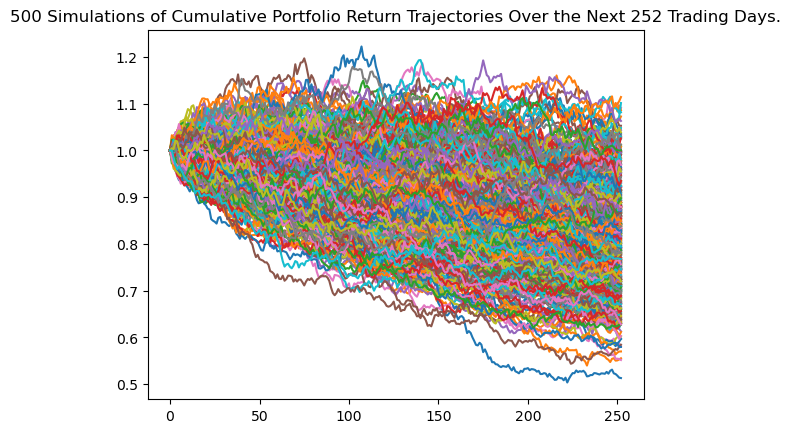

In [121]:
# Visualize the 30-year Monte Carlo simulation by creating an overlay line plot

line_plot_min_portfolio_plot = MC_min_portfolio.plot_simulation()

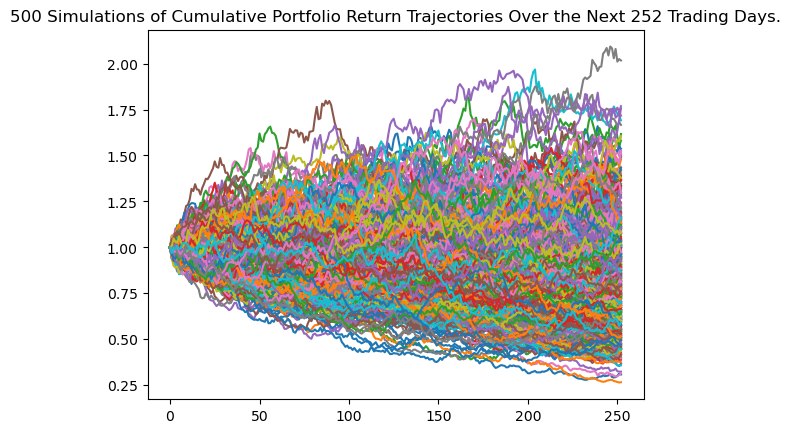

In [122]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
line_plot_max_portfolio_plot = MC_max_portfolio.plot_simulation()

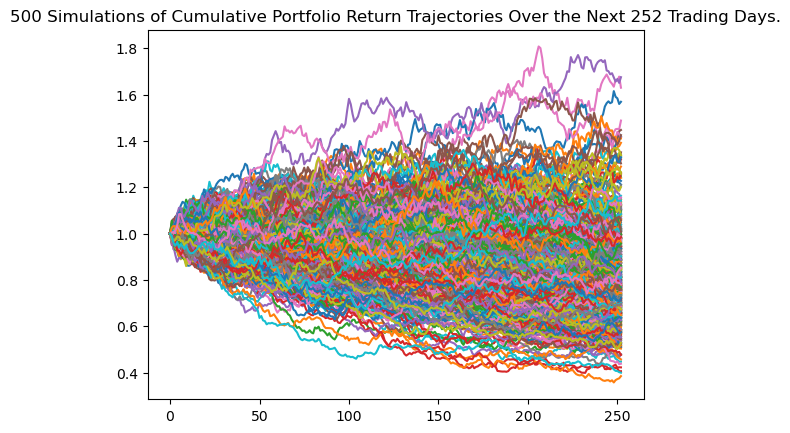

In [123]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
line_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_simulation()

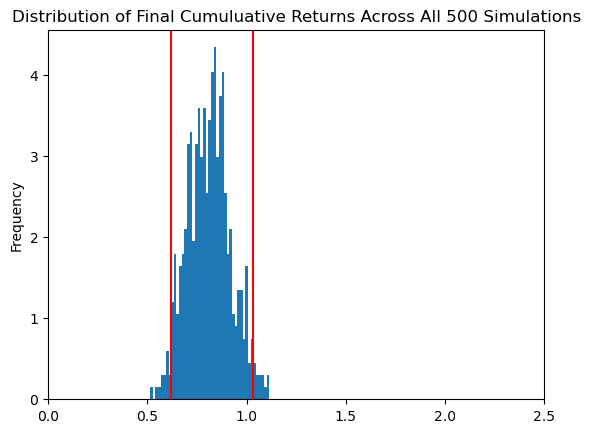

In [139]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_min_portfolio_plot = MC_min_portfolio.plot_distribution()

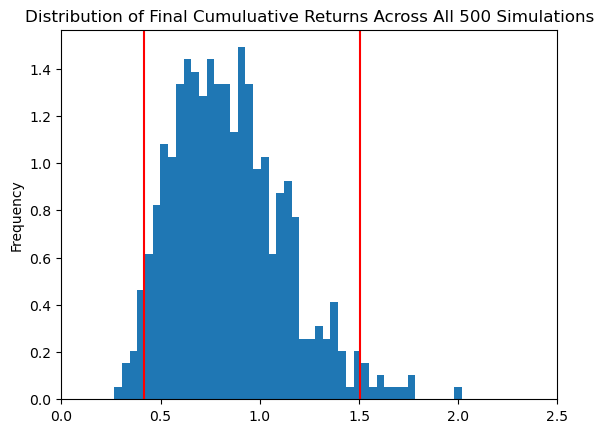

In [140]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_max_portfolio_plot = MC_max_portfolio.plot_distribution()

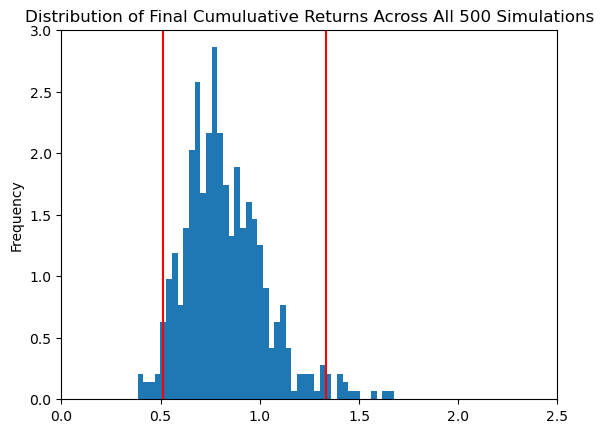

In [141]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_distribution()

In [127]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_min_portfolio_weight = MC_min_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_min_portfolio_weight)

count           500.000000
mean              0.811281
std               0.107925
min               0.513143
25%               0.731194
50%               0.813091
75%               0.879097
max               1.114228
95% CI Lower      0.619948
95% CI Upper      1.030645
Name: 252, dtype: float64


In [128]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_max_portfolio_weight = MC_max_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_max_portfolio_weight)

count           500.000000
mean              0.847407
std               0.284982
min               0.265648
25%               0.631947
50%               0.814206
75%               1.015439
max               2.017190
95% CI Lower      0.416548
95% CI Upper      1.502521
Name: 252, dtype: float64


In [129]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_opt_sharpe_ratio_portfolio_weight = MC_opt_sharpe_ratio_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_opt_sharpe_ratio_portfolio_weight)

count           500.000000
mean              0.825077
std               0.204172
min               0.384707
25%               0.684043
50%               0.794998
75%               0.940504
max               1.675176
95% CI Lower      0.511036
95% CI Upper      1.333657
Name: 252, dtype: float64


In [130]:
# Print the initial investment in the portfolio
print(f"The initial investment of the portfolio is ${mpt.initial_test_investment:0.2f}")

The initial investment of the portfolio is $10000.00


In [131]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MIN portfolio

# Get the lower and upper CI values
ci_lower_95per = table_min_portfolio_weight[8]
ci_upper_95per = table_min_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2)

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current MIN portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_min:0.2f}")


There is a 95% chance that the current MIN portfolio value of $10000.00, will end within the range of $6199.48 and $10306.45.
The actual realized value of the portfolio is $7948.56


In [132]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MAX portfolio

# Get the lower and upper CI values
ci_lower_95per = table_max_portfolio_weight[8]
ci_upper_95per = table_max_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2)
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current MAX portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_max:0.2f}")


There is a 95% chance that the current MAX portfolio value of $10000.00, will end within the range of $4165.48 and $15025.21.
The actual realized value of the portfolio is $7493.96


In [133]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the OPT SHARPE RATIO portfolio

# Get the lower and upper CI values
ci_lower_95per = table_opt_sharpe_ratio_portfolio_weight[8]
ci_upper_95per = table_opt_sharpe_ratio_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current OPT Sharpe Ratio  portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_opt_sharpe_ratio:0.2f}")


There is a 95% chance that the current OPT Sharpe Ratio  portfolio value of $10000.00, will end within the range of $5110.36 and $13336.57.
The actual realized value of the portfolio is $7721.17


### 5. Summary